# **SFN 2019**
## *Uncertainty-based arbitration between incremental and episodic control over decisions*
### Lab sample: Behavior and Pupillometry
---
---
#### **Jonathan Nicholas**
Columbia University

In [34]:
import glob, os, ast, warnings, sys
sys.path.insert(1,"utilities")
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bambi import Model
from scipy.stats import zscore
import pymc3 as pm
import edfreader as edfr
import pystan
import scipy.stats as st

%run utilities/behavioral_analysis_functions.py
%run utilities/pupillometry_analysis_functions.py

palette = ["#66c2a5","#8da0cb"]
sns.set_context("notebook")
sns.set_palette(palette)
sns.set(style="ticks",font="Arial",font_scale=2)

---
# Load Behavioral Data

In [2]:
pids = ["100","101","102","104","105",
        "106","107","108","109","110",
        "111","112","113","114","115",
        "116","117","118","119","120",
        "121","122","123","124","125",
        "126","127","128","129","130"]

# Load all datasets
n_subjects, data = loadLabData(data_dir="/users/jonathan/shohamylab/projects/incep/lab/pilot/data",pids=pids)
n_subjects = len(data.subject_id.unique())

# Get memory data
mem_data = data[data.phase.isin(["recognition_mem","choice_mem","value_mem"])]
mem_data = mem_data[["subject_id","condition","mem_trial_number","object_type","object","environment","value","response","phase"]]

# Clean data and add relevant columns
data = cleanData(data=data)

# Get only data with previously seen objects and add relevant columns 
old_data = getOldData(data=data)

---
# Run model to test for sensitivity to old object value in each environment

In [4]:
object_model = Model(old_data, dropna=True)
object_fit = object_model.fit("old_chosen ~ old_value*environment*condition",
                        random=['old_value*environment*condition|subject_id'],
                        family='bernoulli', samples=3000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 3,106.4:  60%|█████▉    | 29776/50000 [01:20<00:54, 370.19it/s]
Convergence achieved at 29800
INFO:pymc3.variational.inference:Convergence achieved at 29800
Interrupted at 29,799 [59%]: Average Loss = 3,974.4
INFO:pymc3.variational.inference:Interrupted at 29,799 [59%]: Average Loss = 3,974.4
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [old_value:environment[T.volatile]:condition[T.volstab]|subject_id_offset, old_value:environment[T.volatile]:condition[T.volstab]|subject_id_sd, old_value:condition[T.volstab]|subject_id_offset, old_value:condition[T.volstab]|subject_id_sd, old_value:environment[T.volatile]|subject_id_offset, old_value:environment[T.volatile]|subject_id_sd, old_value|subject_id_offset, old_value|subject_id_sd, environment[T.volatile]:condition[T.volstab

In [5]:
ppc_object = pm.sampling.sample_ppc(object_model.backend.trace, samples=1000, model=object_model.backend.model)

100%|██████████| 1000/1000 [00:04<00:00, 239.30it/s]


In [6]:
predictors = ['old_value','environment','condition',
              'old_value:environment','old_value:condition','environment:condition',
              'old_value:environment:condition']
pm.summary(object_model.backend.trace,var_names=predictors)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
old_value__0,1.251387,0.245681,0.007931,0.784688,1.743115,861.907706,1.004550
environment__0,0.229054,0.151582,0.004460,-0.063690,0.522076,1150.492148,1.001516
condition__0,0.062552,0.259927,0.008020,-0.443301,0.571748,905.590961,1.002595
old_value:environment__0,-0.765859,0.275673,0.007897,-1.299201,-0.229928,1127.292781,1.001522
old_value:condition__0,0.102741,0.406830,0.013007,-0.696948,0.880526,852.624794,1.004980
environment:condition__0,-0.172897,0.233326,0.007081,-0.631223,0.283880,1000.464659,1.002009
old_value:environment:condition__0,0.629961,0.455511,0.013048,-0.253036,1.517638,1107.151279,1.001226


## Group-level model fit

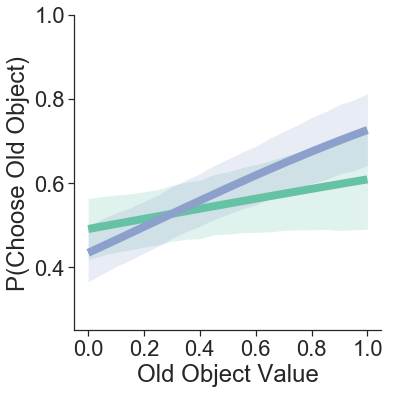

In [11]:
f = plot_2way_logistic_single(data=old_data,
                              ppc=ppc_object, #posterior predictive
                              model_fit=object_fit, #fit model
                              y_var="old_chosen", #outcome variable
                              y_label="P(Choose Old Object)",
                              x_var="old_value", #predictor variable to plot on x-axis
                              x_label="Old Object Value",
                              x_factors=[np.arange(0,1.05,0.05),np.arange(0,1.05,0.05)], # range of x values to plot on
                              x_scaler=[5,5], # if scaling is needed to plot x-axis for each of the ranges
                              col_var="environment", #predictor variable to break into separate plots
                              col_factors=[1,0], # corresponds to factors in the model
                              plot_order=[0,1], # corresponds to order in which col variables should be plotted (plot first value in col_factor on first axis)
                              )
f.savefig("figures/figure1_grp_lab.pdf")

## Individual model fits and raw data

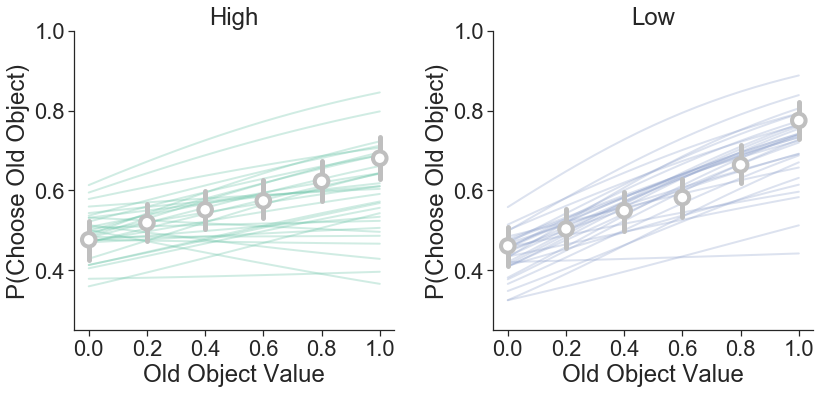

In [15]:
f = plot_2way_logistic(data=old_data,
                       ppc=ppc_object, #posterior predictive
                       model_fit=object_fit, #fit model
                       y_var="old_chosen", #outcome variable
                       y_label="P(Choose Old Object)",
                       x_var="old_value", #predictor variable to plot on x-axis
                       x_label="Old Object Value",
                       x_factors=[np.arange(0,1.05,0.05),np.arange(0,1.05,0.05)], # range of x values to plot on
                       x_scaler=[5,5], # if scaling is needed to plot x-axis for each of the ranges
                       col_var="environment", #predictor variable to break into separate plots
                       col_factors=[1,0], # corresponds to factors in the model
                       plot_order=[0,1], # corresponds to order in which col variables should be plotted (plot first value in col_factor on first axis)
                       )
f.savefig("figures/figure1_indivs_lab.pdf")

## Effect of Old Object Value x Environment

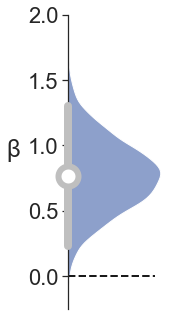

In [16]:
mean = np.mean(-object_model.backend.trace["old_value:environment"]) # reversing effect coding for more interpretable visualization
hpd = pm.stats.hpd(-object_model.backend.trace["old_value:environment"])[0]

f, ax = plt.subplots(1,1,figsize=(3,5))
ax.plot((0,1.35),(0,0),'k--',linewidth=2)
o = ax.plot(0,mean,'o',ms=20,mfc='w',mew=6,zorder=50,color='.75')[0]
o.set_clip_on(False)
l = ax.plot((0,0),(hpd[0],hpd[1]),linewidth=8,color='.75',zorder=49)[0]
l.set_clip_on(False)
sns.distplot(-object_model.backend.trace["old_value:environment"],kde_kws={'linewidth':0,'bw':0.05,'shade':True,'color':palette[1],'alpha':1},ax=ax,kde=True,color=palette[1],vertical=True,hist=False)
ax.set_xticks([])
ax.set_ylim((-0.25,2))
ax.set_ylabel("β   ",rotation=0)
plt.tight_layout()
sns.despine(bottom=True);
f.savefig("figures/figure1_effect_lab.pdf")

---
# Run model to test for sensitivity to incrementally constructed value

In [17]:
inc_choices = get_inc_choices(data)

model_str1 = "outcome_t1:orange_chosen_t1 + "+ \
             "outcome_t2:orange_chosen_t2 + "+ \
             "outcome_t3:orange_chosen_t3 + " + \
             "outcome_t4:orange_chosen_t4 + " + \
             "outcome_t1:orange_chosen_t1:environment_t1 + "+ \
             "outcome_t2:orange_chosen_t2:environment_t2 + "+ \
             "outcome_t3:orange_chosen_t3:environment_t3 + " + \
             "outcome_t4:orange_chosen_t4:environment_t4"
model_str2 = "("+model_str1+")"+"|subject_id"
inc_model = Model(inc_choices,dropna=True)
inc_fit = inc_model.fit("orange_chosen ~ "+model_str1,random=[model_str2],family='bernoulli',
                        samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 5,038.9:  52%|█████▏    | 26176/50000 [01:53<01:43, 230.53it/s]
Convergence achieved at 26200
INFO:pymc3.variational.inference:Convergence achieved at 26200
Interrupted at 26,199 [52%]: Average Loss = 5,898.9
INFO:pymc3.variational.inference:Interrupted at 26,199 [52%]: Average Loss = 5,898.9
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outcome_t4:orange_chosen_t4:environment_t4[T.volatile]|subject_id_offset, outcome_t4:orange_chosen_t4:environment_t4[T.volatile]|subject_id_sd, outcome_t4:orange_chosen_t4|subject_id_offset, outcome_t4:orange_chosen_t4|subject_id_sd, outcome_t3:orange_chosen_t3:environment_t3[T.volatile]|subject_id_offset, outcome_t3:orange_chosen_t3:environment_t3[T.volatile]|subject_id_sd, outcome_t3:orange_chosen_t3|subject_id_offset, outcome_t3:ora

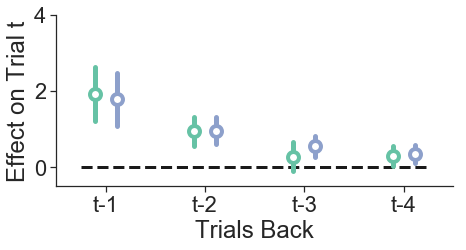

In [18]:
f, axes = plt.subplots(1,1,figsize=(7,4))

plt.plot([-0.25,3.25],[0,0],'k--',linewidth=3)

vars2plt = ['outcome_t1:orange_chosen_t1','outcome_t2:orange_chosen_t2',
            'outcome_t3:orange_chosen_t3','outcome_t4:orange_chosen_t4']
ints2plt = ['outcome_t1:orange_chosen_t1:environment_t1','outcome_t2:orange_chosen_t2:environment_t2',
            'outcome_t3:orange_chosen_t3:environment_t3','outcome_t4:orange_chosen_t4:environment_t4']
for v_i, v in enumerate(vars2plt):
    plt.plot([v_i+0.11,v_i+0.11],pm.stats.hpd(inc_model.backend.trace[v])[0],color=palette[1],linewidth=5)
    plt.scatter(v_i+0.11,np.mean(inc_model.backend.trace[v]),color=palette[1],s=120,linewidth=4)
    
    intvals = inc_model.backend.trace[v]+inc_model.backend.trace[ints2plt[v_i]]
    plt.plot([v_i-0.11,v_i-0.11],pm.stats.hpd(intvals)[0],color=palette[0],linewidth=5)
    plt.scatter(v_i-0.11,np.mean(intvals),color=palette[0],s=120,linewidth=4)
    
plt.setp(axes.collections, facecolor="w",zorder=50)

plt.gca().set_ylim(-0.5,4)
plt.gca().set_xlim(-0.5,3.5)
plt.gca().set_ylabel("Effect on Trial t")
plt.gca().set_xlabel("Trials Back")
plt.gca().set_xticks(range(4))
plt.gca().set_xticklabels(["t-1","t-2","t-3","t-4"])
plt.tight_layout()
sns.despine();

f.savefig("figures/figure2_lab.pdf")

---
# Compute d-prime and test for difference between environments

In [19]:
recog_data = mem_data[mem_data.phase == "recognition_mem"]
recog_data['response_type'] = recog_data.apply(lambda row: signal_detect(row),axis=1)
sdt_data = recog_data.groupby(["subject_id","environment","response_type"]).size().unstack(fill_value=0).stack().reset_index(name="num_responses")
dprime_df = {'environment':[],'subject_id':[],'dprime':[]}
for subj in sdt_data.subject_id.unique():
    subj_data = sdt_data[sdt_data.subject_id == subj]
    for env in ['stable','volatile']:
        env_data = subj_data[subj_data.environment == env]
        dprime = compute_dprime(n_Hit=env_data[env_data.response_type == "hit"].num_responses.iloc[0],
                                n_Miss=env_data[env_data.response_type == "miss"].num_responses.iloc[0],
                                n_FA=env_data[env_data.response_type == "fa"].num_responses.iloc[0],
                                n_CR=env_data[env_data.response_type == "cr"].num_responses.iloc[0])
        dprime_df['subject_id'].append(subj)
        dprime_df['environment'].append(env)
        dprime_df['dprime'].append(dprime)
dprime_df = pd.DataFrame.from_dict(dprime_df)

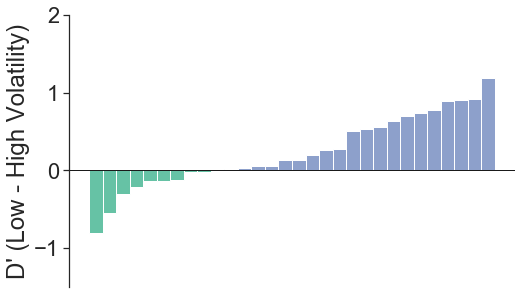

In [20]:
dprime_diffs = np.array(dprime_df[dprime_df.environment == "stable"].dprime) - np.array(dprime_df[dprime_df.environment == "volatile"].dprime)

cols = []
for i in np.sort(dprime_diffs):
    if i <= 0: cols.append(palette[0])
    else: cols.append(palette[1])
        
f, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(np.arange(len(dprime_diffs)), np.sort(dprime_diffs),width=1,color=cols)
plt.plot((-2,31),(0,0),'k',linewidth=1)
plt.xticks([])
ax.set_ylabel("D' (Low - High Volatility)")
plt.xlim((-2,31))
plt.ylim((-1.5,2))
sns.despine(bottom=True);
f.savefig("figures/figure3_lab.pdf")

In [21]:
dprime_model = Model(dprime_df, dropna=True)

dprime_fit = dprime_model.fit("dprime ~ environment",random=['environment|subject_id'],samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 82.607:  24%|██▍       | 11921/50000 [00:08<00:25, 1469.94it/s]
Convergence achieved at 12000
INFO:pymc3.variational.inference:Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 142.77
INFO:pymc3.variational.inference:Interrupted at 11,999 [23%]: Average Loss = 142.77
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dprime_sd, environment[T.volatile]|subject_id_offset, environment[T.volatile]|subject_id_sd, 1|subject_id_offset, 1|subject_id_sd, environment, Intercept]
INFO:pymc3:NUTS: [dprime_sd, environment[T.volatile]|subject_id_offset, environment[T.volatile]|subject_id_sd, 1|subject_id_offset, 1|subject_id_sd, environment, Intercept]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:34<00:00, 126.59draws/s]
The acceptance probability does not 

## Effect of environment

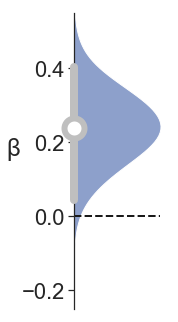

In [22]:
mean = np.mean(-dprime_model.backend.trace['environment'])
hpd = pm.stats.hpd(-dprime_model.backend.trace['environment'])[0]

f, ax = plt.subplots(1,1,figsize=(3,5))
ax.plot((0,3.8),(0,0),'k--',linewidth=2)
o = ax.plot(0,mean,'o',ms=20,mfc='w',mew=6,zorder=50,color='.75')[0]
o.set_clip_on(False)
l = ax.plot((0,0),(hpd[0],hpd[1]),linewidth=8,color='.75',zorder=49)[0]
l.set_clip_on(False)
sns.distplot(-dprime_model.backend.trace['environment'],kde_kws={'linewidth':0,'bw':0.05,'shade':True,'color':palette[1],'alpha':1},ax=ax,kde=True,color=palette[1],vertical=True,hist=False)
ax.set_ylabel("β ",rotation=0)
ax.set_xticks([])
ax.set_ylim((-0.25,0.55))
plt.tight_layout()
sns.despine(bottom=True);
f.savefig("figures/figure3_effect_lab.pdf")

---
# Load and preprocess eye tracking data

In [25]:
eye_pids = pids.copy()
# An accurate eyetracking calibration was not achieved for 
# these three participants due to issues with eye makeup/tattoos and glasses
eye_pids.remove("105")
eye_pids.remove("107")
eye_pids.remove("108")

eye_data = load_eyetracking_data("/users/jonathan/shohamylab/projects/incep/lab/pilot/data",eye_pids)

In [27]:
pupil_data = get_pupil_data(eye_data,eye_pids)
pupil_data = preprocess_pupil_data(pupil_data)
behav_data = data[["trial_number","subject_id","environment","condition","switch_trial",'t_since_reversal','old_trial','old_value','old_chosen']]
pupil_data = pupil_data.merge(behav_data,on=["subject_id","trial_number"])
mean_pupil_data = pupil_data.groupby(["subject_id","environment","condition",'t_since_reversal',"old_trial","trial_number"])["sizeZ"] \
                            .mean().reset_index(name="meanPupilZ")

---
# Run model to test effects of trials since reversal, environment, and previously seen objects on pupil size

In [28]:
pupil_model = Model(mean_pupil_data, dropna=True)

pupil_fit = pupil_model.fit("meanPupilZ ~ trial_number + t_since_reversal*environment*old_trial",
                        random=['trial_number + t_since_reversal*environment*old_trial|subject_id'], samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 7,398.8: 100%|██████████| 50000/50000 [02:48<00:00, 296.29it/s]   
Finished [100%]: Average Loss = 7,398
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 7,398
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [meanPupilZ_sd, t_since_reversal:environment[T.volatile]:old_trial[T.True]|subject_id_offset, t_since_reversal:environment[T.volatile]:old_trial[T.True]|subject_id_sd, t_since_reversal:old_trial[T.True]|subject_id_offset, t_since_reversal:old_trial[T.True]|subject_id_sd, t_since_reversal:environment[T.volatile]|subject_id_offset, t_since_reversal:environment[T.volatile]|subject_id_sd, t_since_reversal|subject_id_offset, t_since_reversal|subject_id_sd, trial_number|subject_id_offset, trial_number|subject_id_sd, environment[T.volatile]:old_trial[T.True]|

In [ ]:
pm.summary(pupil_model.backend.trace).head(9)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept__0,0.450965,0.093711,0.002272,0.270214,0.638835,1779.504112,0.999933
environment__0,0.024539,0.092454,0.002804,-0.153590,0.212827,1094.786634,1.001080
old_trial__0,-0.138641,0.038088,0.000512,-0.212673,-0.065292,5819.942616,0.999893
environment:old_trial__0,-0.031669,0.053299,0.000730,-0.136029,0.070572,5227.058164,1.000026
trial_number__0,-0.002269,0.000702,0.000020,-0.003574,-0.000854,1022.286900,1.001507
t_since_reversal__0,-0.004768,0.001193,0.000017,-0.007087,-0.002449,5443.988936,1.000212
t_since_reversal:environment__0,-0.009564,0.002924,0.000040,-0.015231,-0.003757,4398.264587,1.000443
t_since_reversal:old_trial__0,0.005399,0.001325,0.000017,0.002800,0.007976,6161.005150,0.999797
t_since_reversal:environment:old_trial__0,0.008162,0.002947,0.000031,0.002455,0.013927,6445.191067,0.999962


In [ ]:
ppc_pupil = pm.sampling.sample_ppc(pupil_model.backend.trace, samples=1000, model=pupil_model.backend.model)

100%|██████████| 1000/1000 [00:05<00:00, 179.36it/s]


## Effect when choices are between new objects only

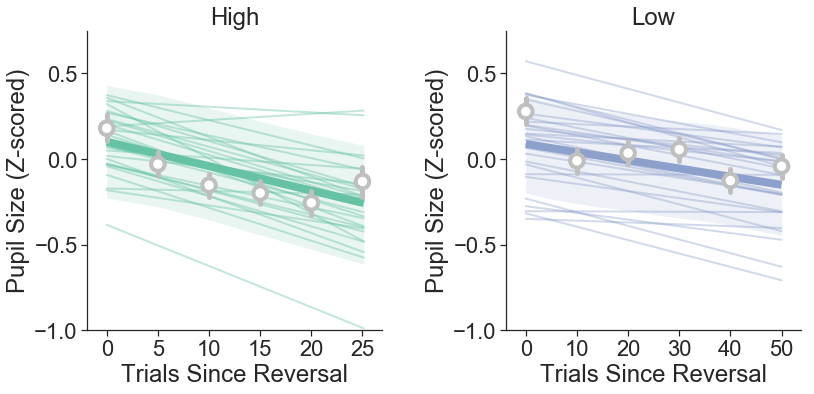

In [35]:
f = plot_3way_pupils(fit_model=pupil_fit,mean_pupil_data=mean_pupil_data,old=0)
f.savefig("figures/figure4A_lab.pdf")

## Effect when one choice features an old object

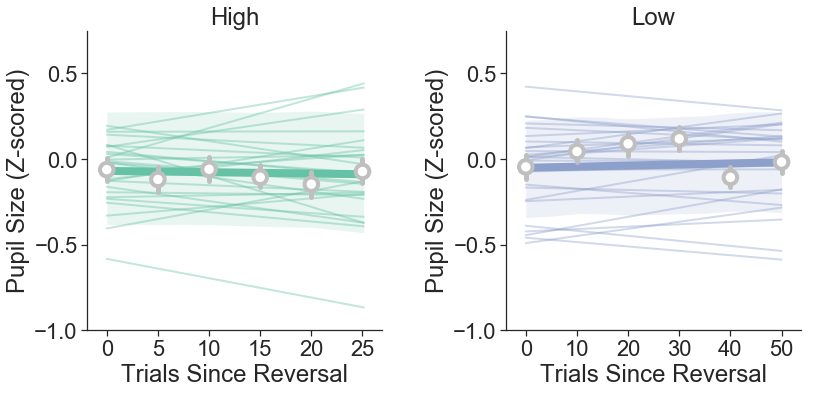

In [37]:
f = plot_3way_pupils(fit_model=pupil_fit,mean_pupil_data=mean_pupil_data,old=1)
f.savefig("figures/figure4B_lab.pdf")